# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datajoint as dj

import u19_pipeline.ephys_pipeline as ephys_pipeline
import u19_pipeline.utils.ephys_utils as ephys_utils
import u19_pipeline.utils.ephys_fix_sync_code as ephys_fix_sync_code


[2026-02-03 11:55:41,741][INFO]: DataJoint 0.14.4 connected to alvaros@datajoint00.pni.princeton.edu:3306


In [3]:
recording_query = "recording_id > 500 and recording_id < 550"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_keys = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


session_fields = ['subject_fullname', 'session_date', 'session_number']
session_keys = (recording.Recording.BehaviorSession & recording_query).fetch(*session_fields, as_dict=True, order_by='recording_id')


recording_keys

[{'recording_id': np.int64(501)},
 {'recording_id': np.int64(502)},
 {'recording_id': np.int64(503)},
 {'recording_id': np.int64(504)},
 {'recording_id': np.int64(505)},
 {'recording_id': np.int64(506)},
 {'recording_id': np.int64(507)},
 {'recording_id': np.int64(508)},
 {'recording_id': np.int64(509)},
 {'recording_id': np.int64(510)},
 {'recording_id': np.int64(511)},
 {'recording_id': np.int64(512)},
 {'recording_id': np.int64(513)},
 {'recording_id': np.int64(514)},
 {'recording_id': np.int64(515)},
 {'recording_id': np.int64(516)},
 {'recording_id': np.int64(517)},
 {'recording_id': np.int64(518)},
 {'recording_id': np.int64(519)},
 {'recording_id': np.int64(520)},
 {'recording_id': np.int64(521)},
 {'recording_id': np.int64(522)},
 {'recording_id': np.int64(523)},
 {'recording_id': np.int64(524)},
 {'recording_id': np.int64(525)},
 {'recording_id': np.int64(526)},
 {'recording_id': np.int64(527)},
 {'recording_id': np.int64(528)},
 {'recording_id': np.int64(529)},
 {'recording_i

In [4]:
def main_ephys_fix_sync_code(iter_start_idx, iter_times_idx, behavior_time, nidq_sampling_rate, key):
    iteration_dict = dict()
    iteration_dict['iter_start_idx']  = list()
    iteration_dict['iter_times_idx']  = list()
    iteration_dict['trial_sync_stats'] = list()

    for i in range(len(iter_start_idx)):

        trial_stats_dict= {}
        trial_stats_dict['num_trial'] = i+1

        #print('fixing trial ',i)
        behavior_time_vector = behavior_time[i].flatten()

        #time_iteration = np.median(np.diff(behavior_time[0:5])

        iter_times_idx[i] = iter_times_idx[i]+behavior_time_vector[1]
        #iter_times_idx[i] = iter_times_idx[i]+behavior_time_vector[1]-(behavior_time_vector[2]-iter_times_idx[i][2])
        #iter_times_idx[i] = iter_times_idx[i]+behavior_time_vector[1]
        #synced_time_vector = np.insert(synced_time_vector, 1, behavior_time_vector[1])
        #synced_time_vector[2:] = synced_time_vector[2:]+(behavior_time_vector[2]-synced_time_vector[2])
        #synced_time_vector[0] = 0

        synced_time_vector, shift_vec, median_vec = ephys_fix_sync_code.get_shift_vector(iter_times_idx[i],behavior_time_vector)

        #if median_vec[1] < 0:
        #    print('Trial # median more', i)
        #    raise('Median less than 0')
            
        #    break

        trial_stats_dict['max_shift'] = np.max(shift_vec)
        trial_stats_dict['min_shift'] = np.min(shift_vec)
        trial_stats_dict['median_diff'] = median_vec[1]
        trial_stats_dict['min_diff'] = median_vec[0]
        trial_stats_dict['max_diff'] = median_vec[2]

        synced_time_vector,trial_stats_dict['borrow_step2'] =\
            ephys_fix_sync_code.fix_shifted_sync_vector(synced_time_vector, behavior_time_vector, shift_vec)

        #synced_time_vector, trial_stats_dict['borrow_step3'] =\
        #    fix_sync_vector_greater(synced_time_vector, behavior_time_vector)
        synced_time_vector,trial_stats_dict['borrow_step4'] =\
            ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector, behavior_time_vector)

        synced_iteration_vector =\
            ephys_fix_sync_code.fix_iter_vector(iter_start_idx[i],synced_time_vector, iter_times_idx[i], nidq_sampling_rate)
        
        trial_stats_dict['num_iterations'] = synced_iteration_vector.shape[0] 
        
        trial_stats_dict = trial_stats_dict | key
        iteration_dict['trial_sync_stats'].append(trial_stats_dict)


        iteration_dict['iter_start_idx'].append(synced_iteration_vector.copy())
        iteration_dict['iter_times_idx'].append(synced_time_vector.copy())

    print('end fix sync code 1')

    iteration_dict['iter_start_idx'] = np.asarray(iteration_dict['iter_start_idx'].copy(), dtype=object)
    iteration_dict['iter_times_idx'] = np.asarray(iteration_dict['iter_times_idx'].copy(), dtype=object)

    print('end fix sync code')

    # Check # of trials and iterations match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    print('after assert_iteration_samples_count fix sync code')

    if trial_count_diff != 0:
        print('trial_count_diff', trial_count_diff)
    if len(trials_diff_iteration_big) > 0:
        print('trials_diff_iteration_big', trials_diff_iteration_big)
    if len(trials_diff_iteration_small) > 0:
        print('trials_diff_iteration_small', trials_diff_iteration_small)


    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])

    print('after evaluate_sync_process fix sync code')

    for i in range(len(iteration_dict['iter_start_idx'])):
        synced_time_vector = iteration_dict['iter_times_idx'][i]
        behavior_time_vector = behavior_time[i].flatten()

        status = ephys_fix_sync_code.sync_evaluation_process2(synced_time_vector, behavior_time_vector)
        if status == -1:
            break

    print('after sync_evaluation_process2', status)

    if status == 1:
        iteration_dict['trial_start_idx'] = ephys_utils.get_index_trial_vector_from_iteration(iteration_dict['iter_start_idx'])


    return status, iteration_dict

In [5]:
def main_regular_sync(key, **kwargs):

    ephys_session_fullpath = ephys_pipeline.get_full_session_directory(key)

    # Get behavior key
    behavior_key = (recording.Recording.BehaviorSession & key).fetch1()
    behavior_key.pop('recording_id')

    if 'testuser' in behavior_key['subject_fullname']:
        return

    # If a specific block is requested, add that to our behavior_key. It should be an int referring to virmen block number.
    # This is useful for sessions in which the nidaq stream was interrupted due to restarting virmen
    if 'block' in kwargs:
        print('block: ', kwargs['block'])
        behavior_key['block'] = kwargs['block']

    print(behavior_key)

    # And get the datajoint record
    behavior = dj.create_virtual_module('behavior', 'u19_behavior')
    thissession = behavior.TowersBlock().Trial() & behavior_key
    behavior_time, iterstart = thissession.fetch('trial_time', 'vi_start')

    print('len iterstart', len(iterstart))

    if len(iterstart) == 0:
        raise ValueError('No behavior found')

    print('after reading behavior data')

    # 1: load meta data, and the content of the NIDAQ file. Its content is digital.
    nidq_meta, nidq_sampling_rate = ephys_utils.read_nidq_meta_samp_rate(ephys_session_fullpath)

    trial_pulse_signal, iteration_pulse_signal = ephys_utils.load_trial_iteration_signals(ephys_session_fullpath, nidq_meta)

    print('after reading spikeglx data')

    # Synchronize between pulses and get iteration # vector for each sample
    recent_recording = behavior_key['session_date'] > datetime.date(2021,6,1) # Everything past June 1 2021
    if recent_recording:
        # New synchronization method: digital_array[1,2] contain pulses for trial and frame number.
        mode=None
        iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal, nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode)
    else:
        # Old synchronization: digital_array[0:7] contain a digital word that counts the virmen frames.
        raise ValueError('Old sessions < 2022 not suported anymore')
        #iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_word(digital_array, behavior_time, iterstart)

    # Check # of trials (from database record of behavior in `behavior_time`) and iterations (extracted from NIDAQ in `iter_start_idx`) match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    print('metrics to evaluate...')
    print(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small, behavior_time.shape[0])

    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small, behavior_time.shape[0])

    if status == 1:
        iteration_dict['trial_start_idx'] = ephys_utils.get_index_trial_vector_from_iteration(iteration_dict['iter_start_idx'])

    #Failed sync by a lot, error
    status_regular = 1
    status_fix = 0
    if status < 1:
        status_regular = 0
        print('Regular ephys sync failed')
    
    try:
        status_fix, iteration_dict2 = main_ephys_fix_sync_code(iteration_dict['iter_start_idx'], iteration_dict['iter_times_idx'], behavior_time, nidq_sampling_rate, key)
    except:
        status_fix = 0
        iteration_dict2 = {}

    return status_fix, iteration_dict2

In [6]:

num_session = 0
for idx_session in range(len(recording_keys)):

    recording_key = recording_keys[idx_session]
    session_key = session_keys[idx_session]

    status_fix, iteration_dict2 = main_regular_sync(recording_key)
    if status_fix == 0:
        continue

    print('session_key', session_key)

    for i in range(len(iteration_dict2['trial_sync_stats'])):
        iteration_dict2['trial_sync_stats'][i] = iteration_dict2['trial_sync_stats'][i] | session_key

    print('status_fix', status_fix)
    print('num_session', num_session)
    
    if num_session == 0:
        trial_sync_stats_df = pd.DataFrame(iteration_dict2['trial_sync_stats'])
    else:
        trial_sync_stats_df = pd.concat([trial_sync_stats_df, pd.DataFrame(iteration_dict2['trial_sync_stats'])], axis=0)

    num_session += 1

    


/mnt/cup/braininit/Data/Raw/electrophysiology/jyanar/jyanar_ya054/20251012_g0/ya054_20251012_g0
{'subject_fullname': 'jyanar_ya054', 'session_date': datetime.date(2025, 10, 12), 'session_number': 0}
len iterstart 266
after reading behavior data
nChan: 4, nFileSamp: 113704412
after reading spikeglx data
len trial_start_idx (266,)
mode deduction:  pulse_signal
trial# 0 iterPulses: 1113 IterBeh: 1116 Difference ( 3 )
trial# 1 iterPulses: 584 IterBeh: 585 Difference ( 1 )
trial# 2 iterPulses: 469 IterBeh: 470 Difference ( 1 )
trial# 3 iterPulses: 545 IterBeh: 546 Difference ( 1 )
trial# 5 iterPulses: 487 IterBeh: 488 Difference ( 1 )
trial# 6 iterPulses: 475 IterBeh: 477 Difference ( 2 )
trial# 7 iterPulses: 464 IterBeh: 465 Difference ( 1 )
trial# 8 iterPulses: 577 IterBeh: 578 Difference ( 1 )
trial# 9 iterPulses: 460 IterBeh: 461 Difference ( 1 )
trial# 10 iterPulses: 628 IterBeh: 629 Difference ( 1 )
trial# 11 iterPulses: 711 IterBeh: 712 Difference ( 1 )
trial# 12 iterPulses: 572 Iter

/mnt/cup/braininit/Shared/repos/TestU19PipelinePython/U19-pipeline-python/u19_pipeline/utils/ephys_fix_sync_code.py:290: RuntimeWarning: divide by zero encountered in scalar divide
  median_diff_percent[j] = (np.median(diff_vector[start_iter:end_iter])-median_general)*100/median_general


len iterstart 324
after reading behavior data
['0', '7']
nChan: 1, nFileSamp: 18596642
after reading spikeglx data
len trial_start_idx (324,)
mode deduction:  counter_bit0
metrics to evaluate...
0 [] [] 324
Synced perfectly xxxxxxxxxxxxxx
end fix sync code 1
end fix sync code
after assert_iteration_samples_count fix sync code
Synced perfectly xxxxxxxxxxxxxx
after evaluate_sync_process fix sync code
after sync_evaluation_process2 1
session_key {'subject_fullname': 'jk8386_jk44', 'session_date': datetime.date(2024, 7, 25), 'session_number': np.int64(0)}
status_fix 1
num_session 14
/mnt/cup/braininit/Data/Raw/electrophysiology/jk8386/jk8386_jknpx6/20251118_g0/jknpx6_20251118_g0
{'subject_fullname': 'jk8386_jknpx6', 'session_date': datetime.date(2025, 11, 18), 'session_number': 0}
len iterstart 431
after reading behavior data
['0', '7']
nChan: 1, nFileSamp: 17145362
after reading spikeglx data
len trial_start_idx (431,)
mode deduction:  counter_bit0
metrics to evaluate...
0 [] [] 431
Synce

/mnt/cup/braininit/Shared/repos/TestU19PipelinePython/U19-pipeline-python/u19_pipeline/utils/ephys_fix_sync_code.py:290: RuntimeWarning: divide by zero encountered in scalar divide
  median_diff_percent[j] = (np.median(diff_vector[start_iter:end_iter])-median_general)*100/median_general


after sync_evaluation_process2 1
session_key {'subject_fullname': 'jk8386_jknpx6', 'session_date': datetime.date(2025, 11, 18), 'session_number': np.int64(0)}
status_fix 1
num_session 15
/mnt/cup/braininit/Data/Raw/electrophysiology/jk8386/jk8386_jknpx7/20251118_g0/jknpx7_20251118_g0
{'subject_fullname': 'jk8386_jknpx7', 'session_date': datetime.date(2025, 11, 18), 'session_number': 0}
len iterstart 35
after reading behavior data
['0', '7']
nChan: 1, nFileSamp: 18471939
after reading spikeglx data
len trial_start_idx (35,)
mode deduction:  counter_bit0
trial# 16 iterPulses: 48792 IterBeh: 48794 Difference ( 2 )
metrics to evaluate...
0 [] [16] 35
Missed num trials:  0
Missed iteration count in how many trials:  1
Trying to fix trials
Regular ephys sync failed
end fix sync code 1
end fix sync code
after assert_iteration_samples_count fix sync code
Synced perfectly xxxxxxxxxxxxxx
after evaluate_sync_process fix sync code
0.004865220286546901
after sync_evaluation_process2 -1
session_key 

/mnt/cup/braininit/Shared/repos/TestU19PipelinePython/U19-pipeline-python/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/cup/braininit/Shared/repos/TestU19PipelinePython/U19-pipeline-python/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/mnt/cup/braininit/Data/Raw/electrophysiology/jk8386/jk8386_jknpx7/20251125_g0/jknpx7_20251125_g0
{'subject_fullname': 'jk8386_jknpx7', 'session_date': datetime.date(2025, 11, 25), 'session_number': 0}
len iterstart 358
after reading behavior data
['0', '7']
nChan: 1, nFileSamp: 15718642
after reading spikeglx data
len trial_start_idx (358,)
mode deduction:  counter_bit0
metrics to evaluate...
0 [] [] 358
Synced perfectly xxxxxxxxxxxxxx
end fix sync code 1
end fix sync code
after assert_iteration_samples_count fix sync code
Synced perfectly xxxxxxxxxxxxxx
after evaluate_sync_process fix sync code
after sync_evaluation_process2 1
session_key {'subject_fullname': 'jk8386_jknpx7', 'session_date': datetime.date(2025, 11, 25), 'session_number': np.int64(0)}
status_fix 1
num_session 20
/mnt/cup/braininit/Data/Raw/electrophysiology/jk8386/jk8386_jknpx7/20251124_g0/jknpx7_20251124_g0
{'subject_fullname': 'jk8386_jknpx7', 'session_date': datetime.date(2025, 11, 24), 'session_number': 0}
len ite

/mnt/cup/braininit/Shared/repos/TestU19PipelinePython/U19-pipeline-python/u19_pipeline/utils/ephys_fix_sync_code.py:290: RuntimeWarning: divide by zero encountered in scalar divide
  median_diff_percent[j] = (np.median(diff_vector[start_iter:end_iter])-median_general)*100/median_general


after sync_evaluation_process2 1
session_key {'subject_fullname': 'jk8386_jknpx7', 'session_date': datetime.date(2025, 12, 3), 'session_number': np.int64(0)}
status_fix 1
num_session 45
/mnt/cup/braininit/Data/Raw/electrophysiology/jk8386/jk8386_jknpx6/20251222_g0/jknpx6_20251222_g0
{'subject_fullname': 'jk8386_jknpx6', 'session_date': datetime.date(2025, 12, 22), 'session_number': 0}
len iterstart 265
after reading behavior data
['0', '7']
nChan: 1, nFileSamp: 19024132
after reading spikeglx data
len trial_start_idx (265,)
mode deduction:  counter_bit0
metrics to evaluate...
0 [] [] 265
Synced perfectly xxxxxxxxxxxxxx
end fix sync code 1
end fix sync code
after assert_iteration_samples_count fix sync code
Synced perfectly xxxxxxxxxxxxxx
after evaluate_sync_process fix sync code
after sync_evaluation_process2 1
session_key {'subject_fullname': 'jk8386_jknpx6', 'session_date': datetime.date(2025, 12, 22), 'session_number': np.int64(0)}
status_fix 1
num_session 46
/mnt/cup/braininit/Data

In [7]:
def count_borrowed_iter(borrow_list):
    num_borrow = 0
    for i in range(len(borrow_list)):
        num_borrow = num_borrow+ borrow_list[i][1] - borrow_list[i][0] + 1

    return num_borrow


In [8]:

trial_sync_stats_df['min_shift_abs'] = trial_sync_stats_df['min_shift'].abs()
trial_sync_stats_df['shift'] = trial_sync_stats_df[['max_shift', 'min_shift_abs']].max(axis=1)

trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift'] = trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift']*-1

trial_sync_stats_df['num_borrow_step2'] = trial_sync_stats_df['borrow_step2'].apply(count_borrowed_iter)
#trial_sync_stats_df['num_borrow_step3'] = trial_sync_stats_df['borrow_step3'].apply(count_borrowed_iter)
trial_sync_stats_df['num_borrow_step4'] = trial_sync_stats_df['borrow_step4'].apply(count_borrowed_iter)


#trial_sync_stats_df['total_borrow'] = trial_sync_stats_df['num_borrow_step2'] + trial_sync_stats_df['num_borrow_step3'] + trial_sync_stats_df['num_borrow_step4']  

trial_sync_stats_df['total_borrow'] = trial_sync_stats_df['num_borrow_step4'] + trial_sync_stats_df['num_borrow_step2']

trial_sync_stats_df['percentage_borrow'] = trial_sync_stats_df['total_borrow']*100 / trial_sync_stats_df['num_iterations']


trial_sync_stats_df

,num_trial,max_shift,min_shift,median_diff,min_diff,max_diff,borrow_step2,borrow_step4,num_iterations,recording_id,subject_fullname,session_date,session_number,min_shift_abs,shift,num_borrow_step2,num_borrow_step4,total_borrow,percentage_borrow
0,1,0,-2,0.028142,0.021142,0.035142,"[[1015, 1021]]","[[1112, 1115]]",1116,501,jyanar_ya054,2025-10-12,0,2,-2,7,4,11,0.985663
1,2,0,0,0.025619,0.018619,0.032619,[],"[[583, 584]]",585,501,jyanar_ya054,2025-10-12,0,0,0,0,2,2,0.341880
2,3,0,0,0.024462,0.017462,0.031462,[],"[[468, 469]]",470,501,jyanar_ya054,2025-10-12,0,0,0,0,2,2,0.425532
3,4,0,0,0.021488,0.014488,0.028488,[],"[[544, 545]]",546,501,jyanar_ya054,2025-10-12,0,0,0,0,2,2,0.366300
4,5,0,0,0.009041,0.002041,0.016041,[],[],487,501,jyanar_ya054,2025-10-12,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,166,0,0,-0.000013,-0.007013,0.006987,[],[],1299,549,emdia_penny,2025-12-18,0,0,0,0,0,0,0.000000
166,167,0,0,0.000075,-0.006925,0.007075,[],[],1510,549,emdia_penny,2025-12-18,0,0,0,0,0,0,0.000000
167,168,0,0,-0.000203,-0.007203,0.006797,[],[],2252,549,emdia_penny,2025-12-18,0,0,0,0,0,0,0.000000
168,169,0,0,0.000123,-0.006877,0.007123,[],[],1998,549,emdia_penny,2025-12-18,0,0,0,0,0,0,0.000000


In [9]:
trial_sync_stats_df = trial_sync_stats_df.sort_values(by='median_diff', ascending=True)
trial_sync_stats_df

,num_trial,max_shift,min_shift,median_diff,min_diff,max_diff,borrow_step2,borrow_step4,num_iterations,recording_id,subject_fullname,session_date,session_number,min_shift_abs,shift,num_borrow_step2,num_borrow_step4,total_borrow,percentage_borrow
0,1,0,0,-0.004603,-0.011603,0.002397,[],[],1476,516,jk8386_jknpx6,2025-11-18,0,0,0,0,0,0,0.000000
0,1,0,0,-0.004440,-0.011440,0.002560,[],[],1533,518,jk8386_jknpx6,2025-11-19,0,0,0,0,0,0,0.000000
0,1,0,0,-0.004434,-0.011434,0.002566,[],[],1975,533,jk8386_jknpx6,2025-12-11,0,0,0,0,0,0,0.000000
0,1,0,0,-0.004088,-0.011088,0.002912,[],[],1705,536,jk8386_jknpx6,2025-12-15,0,0,0,0,0,0,0.000000
0,1,0,0,-0.004031,-0.011031,0.002969,[],[],2208,549,emdia_penny,2025-12-18,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,190,0,0,0.061985,0.054985,0.068985,[],"[[939, 943]]",944,506,jyanar_ya054,2025-10-18,0,0,0,0,5,5,0.529661
195,196,0,-2,0.065428,0.058428,0.072428,"[[22, 26], [73, 77]]","[[960, 965]]",966,506,jyanar_ya054,2025-10-18,0,2,-2,10,6,16,1.656315
235,236,0,0,0.070593,0.063593,0.077593,[],"[[972, 977]]",978,506,jyanar_ya054,2025-10-18,0,0,0,0,6,6,0.613497
201,202,0,-4,0.081154,0.074154,0.088154,"[[25, 29], [30, 36], [41, 45]]","[[1430, 1439]]",1440,506,jyanar_ya054,2025-10-18,0,4,-4,17,10,27,1.875000


In [12]:
trial_sync_stats_df.loc[trial_sync_stats_df['median_diff'] < -0.0001, :]

,num_trial,max_shift,min_shift,median_diff,min_diff,max_diff,borrow_step2,borrow_step4,num_iterations,recording_id,subject_fullname,session_date,session_number,min_shift_abs,shift,num_borrow_step2,num_borrow_step4,total_borrow,percentage_borrow
0,1,0,0,-0.004603,-0.011603,0.002397,[],[],1476,516,jk8386_jknpx6,2025-11-18,0,0,0,0,0,0,0.0
0,1,0,0,-0.004440,-0.011440,0.002560,[],[],1533,518,jk8386_jknpx6,2025-11-19,0,0,0,0,0,0,0.0
0,1,0,0,-0.004434,-0.011434,0.002566,[],[],1975,533,jk8386_jknpx6,2025-12-11,0,0,0,0,0,0,0.0
0,1,0,0,-0.004088,-0.011088,0.002912,[],[],1705,536,jk8386_jknpx6,2025-12-15,0,0,0,0,0,0,0.0
0,1,0,0,-0.004031,-0.011031,0.002969,[],[],2208,549,emdia_penny,2025-12-18,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,105,0,0,-0.000101,-0.007101,0.006899,[],[],656,532,jk8386_jknpx6,2025-12-09,0,0,0,0,0,0,0.0
187,188,0,0,-0.000101,-0.007101,0.006899,[],[],1220,530,jk8386_jknpx6,2025-12-04,0,0,0,0,0,0,0.0
210,211,0,0,-0.000100,-0.007100,0.006900,[],[],1132,515,jk8386_jk44,2024-07-25,0,0,0,0,0,0,0.0
122,123,0,0,-0.000100,-0.007100,0.006900,[],[],2110,542,jk8386_jknpx7,2025-11-26,0,0,0,0,0,0,0.0


In [13]:
trial_sync_stats_df['min_shift_abs'].max()

np.int64(65)

Text(0.5, 1.0, 'Median diff NIDAQ - ViRMEn')

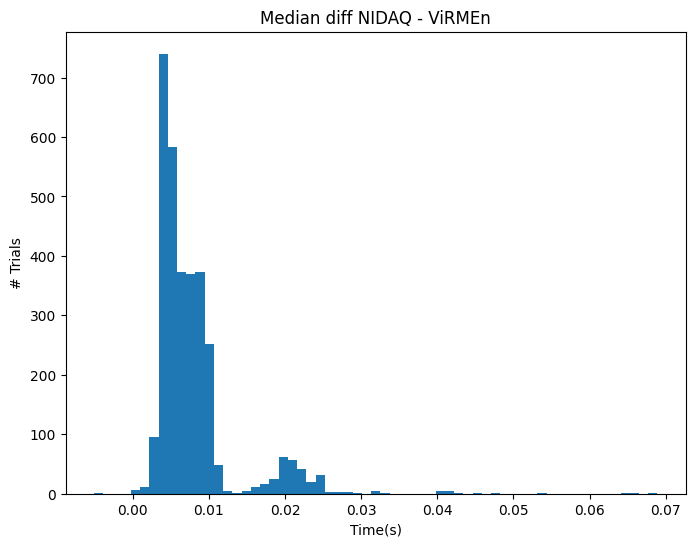

In [14]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['median_diff'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts,bins=61)


plt.xlabel('Time(s)')
plt.ylabel('# Trials')
plt.title('Median diff NIDAQ - ViRMEn')

In [28]:

trial_sync_stats_df['min_shift_abs'] = trial_sync_stats_df['min_shift'].abs()
trial_sync_stats_df['shift'] = trial_sync_stats_df[['max_shift', 'min_shift_abs']].max(axis=1)

trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift'] = trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift']*-1


Text(0.5, 1.0, '"Max" shift in trial to preserve median: 3066 trials without shift')

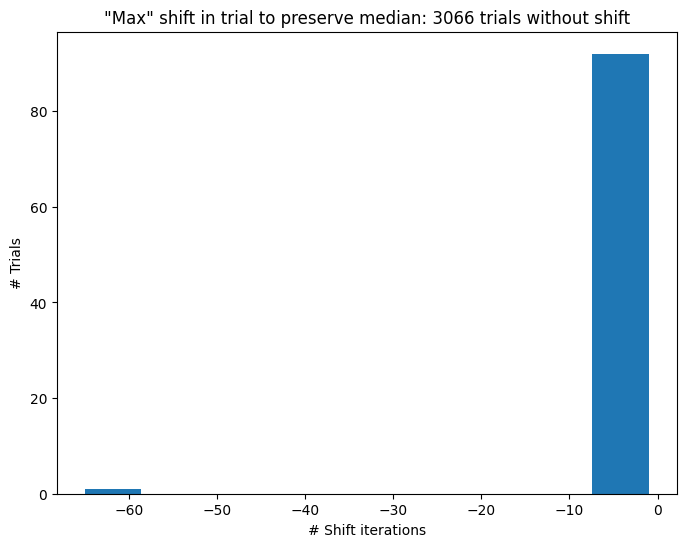

In [29]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['shift'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts)


plt.xlabel('# Shift iterations')
plt.ylabel('# Trials')
plt.title('"Max" shift in trial to preserve median: '+ str(num_0_shifts)+ ' trials without shift')

Text(0.5, 1.0, 'Trial NIDAQ iterations borrowed from ViRMEn')

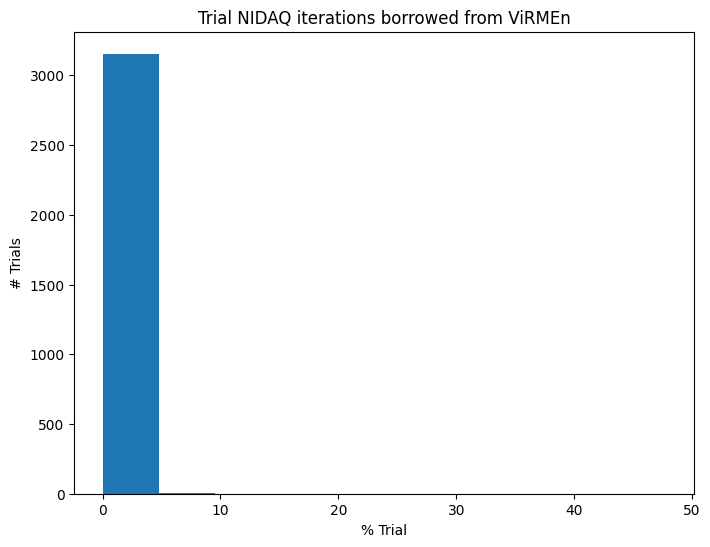

In [30]:
plt.figure(figsize=(8, 6))



plt.hist(trial_sync_stats_df['percentage_borrow'])


plt.xlabel('% Trial')
plt.ylabel('# Trials')
plt.title('Trial NIDAQ iterations borrowed from ViRMEn')

In [14]:
np.max(trial_sync_stats_df['percentage_borrow'])

np.float64(47.80952380952381)